In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import sys
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

In [92]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Accident predict model

In [2]:
#global variable

step3 = 'Clearn_merge_claim_transaction.csv'
#pivot_ridertype_per_claim_count = 'pivot_ridertype_per_claim_count.csv'

all_claim_data_step_3  = pd.read_csv(step3)
#pivot_ridertype_per_claim_count_data = pd.read_csv(pivot_ridertype_per_claim_count) 

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
all_claim_data_step_3.drop(columns=['Unnamed: 0'], inplace = True)

In [4]:
#list of all columns
All_col_name = list(all_claim_data_step_3.columns)
id_col_name = ['policyno', 'unitcode', 'orderno', 'considercode', 'sourceyymm', 'salesid', 'personid', 'referenceid', 'branchconsiderid']
date_col_name = ['accidentdate', 'receivedate', 'claimokdate','claimpaydate', 'effectivedate', 'admitstartdate','admitenddate', 'birthdate']
category_col_name = ['claimtype', 'sectioncode', 'polyear', 'plancode', 'ridertype', 'src_filename', 'groupname', 'branch', 'lcode', 'claimpaytype', 'policystatus1', 'policystatus2', 'causecode1', 'causedetail1', 'causecode2', 'causedetail2', 'hospitalcode', 'provincecode', 'psysiciancertificate', 'admitflag', 'admittype', 'remarkno', 'remarkdesc', 'sourceyymm', 'claimchannel', 'illnesscode', 'illnessdetail', 'contclaimflag', 'msttype', 'contractexcludeflag', 'payerflag', 'payeridno', 'occupationcode', 'branch', 'sex', 'flagfraud', 'nation', 'marriage', 'bankruptcy_flag']
numerical_col_name = ['claimamount', 'tdday', 'pdday', 'admitday', 'sfamount', 'sfrate', 'ansamount', 'oramount', 'deductamount', 'sum', 'insuredage']

In [5]:
for col in id_col_name:
    all_claim_data_step_3[col] = all_claim_data_step_3[col].astype('str')

for col in date_col_name:
    all_claim_data_step_3[col] = pd.to_datetime(all_claim_data_step_3[col], format="%Y-%m-%d", errors='coerce')
    
for col in category_col_name:
     all_claim_data_step_3[col] = all_claim_data_step_3[col].astype('category')

# Feature engineering

In [6]:
all_claim_data_step_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934855 entries, 0 to 2934854
Data columns (total 66 columns):
policyno                object
claimtype               category
accidentdate            datetime64[ns]
receivedate             datetime64[ns]
sectioncode             category
orderno                 object
polyear                 category
claimokdate             datetime64[ns]
claimpaydate            datetime64[ns]
effectivedate           datetime64[ns]
plancode                category
ridertype               category
claimamount             float64
src_filename            category
groupname               category
unitcode                object
branch                  category
lcode                   category
tdday                   int64
pdday                   int64
admitday                int64
admitstartdate          datetime64[ns]
admitenddate            datetime64[ns]
sfamount                float64
sfrate                  float64
ansamount               float64
oramou

In [7]:
# Remarkno 61, 62, 67, 68, 96. We will flag 1.0, other flag 0.0.
all_claim_data_step_3['target'] = all_claim_data_step_3['remarkno'].apply(lambda x: 1.0 if (x == 61)|(x==62)|(x==67)|(x==68)|(x==96) else 0.0)

#filter an acident case.
Acident = all_claim_data_step_3.sort_values(['personid','accidentdate']).loc[all_claim_data_step_3['claimtype'] == 'A']

#filter an error personid with Acident['personid'] != 'n'
Acident = Acident[Acident['personid'] != 'n']

In [8]:
Acident.sort_values(['personid','accidentdate']).head(100)

,policyno,claimtype,accidentdate,receivedate,sectioncode,orderno,polyear,claimokdate,claimpaydate,effectivedate,plancode,ridertype,claimamount,src_filename,groupname,unitcode,branch,lcode,tdday,pdday,admitday,admitstartdate,admitenddate,sfamount,sfrate,ansamount,oramount,deductamount,claimpaytype,policystatus1,policystatus2,causecode1,causedetail1,causecode2,causedetail2,hospitalcode,provincecode,branchconsiderid,considercode,psysiciancertificate,admitflag,admittype,remarkno,remarkdesc,sourceyymm,claimchannel,illnesscode,illnessdetail,contclaimflag,msttype,sum,salesid,personid,contractexcludeflag,payerflag,payeridno,occupationcode,branch.1,insuredage,referenceid,sex,birthdate,flagfraud,nation,marriage,bankruptcy_flag,target
884132,21537982,A,2011-01-19,2011-01-21,02,54C04721,4.0,2011-01-24,2011-01-29,2007-09-26,EL,รพ,2000.00,orwk,3.ค่ารักษาพยาบาล สุขภาพ รพ.,36123535.0,361.0,2.0,0,0,2,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,J20.9,NaN,NaN,NaN,3622,NaN,nan,9002944,0.0,Y,Admit,30.0,อนุมัติ,5401.0,4.0,1.0,Acute bronchitis unspecified,N,O,100000.0,0000088230,100,N,O,NaN,0.0,361.0,0.0,1659902406907,M,NaT,2.0,NaN,NaN,N,0.0
1569225,21537982,A,2012-04-04,2012-04-05,02,55W26023,5.0,2012-04-06,2012-04-27,2007-09-26,EL,พ12,8955.00,orsp,3.ค่ารักษาพยาบาล สุขภาพ รพ.,36123535.0,361.0,2.0,0,0,2,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,J18.9,NaN,NaN,NaN,3622,NaN,nan,9002199,0.0,Y,Admit,74.0,อนุมัติ Fax Claim/ส่งเช็ค รพ./การเงิน,5504.0,1.0,1.0,Pneumonia unspecified,N,O,100000.0,0000088230,100,N,O,NaN,0.0,361.0,0.0,1659902406907,M,NaT,2.0,NaN,NaN,N,0.0
562788,21537982,A,2012-12-19,2012-12-22,02,55D02527,6.0,2012-12-27,2013-01-02,2007-09-26,EL,รพ,3000.00,orwk,3.ค่ารักษาพยาบาล สุขภาพ รพ.,36123535.0,361.0,2.0,0,0,3,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,J20.9,NaN,NaN,NaN,3622,NaN,nan,9003244,0.0,Y,Admit,30.0,อนุมัติ,5512.0,4.0,1.0,Acute bronchitis unspecified,N,O,100000.0,0000088230,100,N,O,NaN,0.0,361.0,0.0,1659902406907,M,NaT,2.0,NaN,NaN,N,0.0
1107689,21537982,A,2014-12-16,2014-12-26,10,57A20976,8.0,2015-01-05,2015-01-09,2007-09-26,EL,รพ,3000.00,orwk,3.ค่ารักษาพยาบาล สุขภาพ รพ.,36123535.0,361.0,2.0,0,0,3,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,A09,NaN,NaN,NaN,3612,NaN,nan,9001346,0.0,Y,Admit,30.0,อนุมัติ,5712.0,4.0,1.0,Diarrhoea and gastroenteritis of presumed infe...,N,O,100000.0,0000088230,100,N,O,NaN,0.0,361.0,0.0,1659902406907,M,NaT,2.0,NaN,NaN,N,0.0
2896069,21537982,A,2014-12-28,2015-01-12,10,58A00500,8.0,2015-01-13,2015-01-16,2007-09-26,EL,พ12,16421.00,orsp,3.ค่ารักษาพยาบาล สุขภาพ รพ.,36123535.0,361.0,2.0,0,0,3,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,B08.5,NaN,30,Herpangina,3612,NaN,nan,9004487,0.0,Y,Admit,30.0,อนุมัติ,5801.0,4.0,1.0,Enteroviral vesicular pharyngitis,N,O,100000.0,0000088230,100,N,O,NaN,0.0,361.0,0.0,1659902406907,M,NaT,2.0,NaN,NaN,N,0.0
1916027,25156448,A,2015-06-26,2015-07-09,91,58A26352,16.0,2015-07-13,2015-07-16,1999-09-24,17,รพ,3000.00,orwk,3.ค่ารักษาพยาบาล สุขภาพ รพ.,757074.0,7.0,524.0,0,0,6,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,I64,NaN,30,[โรคอื่นๆ]=หลอดเลือดสมองตีบ,B106,NaN,nan,9005230,0.0,Y,Admit,34.0,โอนเงิน ธ.SCB/สาขาสภากาชาดไทย,5807.0,4.0,1.0,Stroke not specified as haemorrhage or infarct...,N,O,100000.0,0000000310,1000000000007,N,O,NaN,0.0,7.0,45.0,1011002711213,M,NaT,2.0,NaN,NaN,N,0.0
649042,32925169,A,2011-04-06,2011-07-27,14,54A09427,3.0,2011-07-27,2011-08-04,2008-05-15,EQ,อ02,400.00,orwk,2.ค่าทดแทนอุบัติเหตุ อ.2 อ.3,72513082.0,725.0,81.0,7,7,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,W54,NaN,07,แผลที่ขา ซ้าย,B999,NaN,nan,9004067,0.0,N,OPD,30.0,อนุมัติ,5407.0,4.0,0.0,Bitten or struck by dog,N,O,50000.0,0000017241,1000000000010,N,O,NaN,15.0,432.0,10.0,1018009914680,M,NaT,2.0,NaN,NaN,N,0.0
340943,22355009,A,2015-11-29,2016-10-19,93,59A40314,2.0,2016-11-03,2016-11-04,2013-12-02,WG,อ03,1018.00,oewk,2.ค่าทดแทนอุบัติเหตุ อ.2 อ.3,57168243.0,571.0,549.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,W54,NaN,07,สุนัขกัดต้นขาขวา ฉีดบาดทะยักเข็ม 3,5719,NaN,nan,9005023,0.0,N,OPD,36.0,อนุมัติ/ส่งเช็คไปสาขา/แนบเรื่อง/คืนคลัง,5910.0,4.0,0.0,

In [9]:
Acident[Acident['target'] == 1.0]

,policyno,claimtype,accidentdate,receivedate,sectioncode,orderno,polyear,claimokdate,claimpaydate,effectivedate,plancode,ridertype,claimamount,src_filename,groupname,unitcode,branch,lcode,tdday,pdday,admitday,admitstartdate,admitenddate,sfamount,sfrate,ansamount,oramount,deductamount,claimpaytype,policystatus1,policystatus2,causecode1,causedetail1,causecode2,causedetail2,hospitalcode,provincecode,branchconsiderid,considercode,psysiciancertificate,admitflag,admittype,remarkno,remarkdesc,sourceyymm,claimchannel,illnesscode,illnessdetail,contclaimflag,msttype,sum,salesid,personid,contractexcludeflag,payerflag,payeridno,occupationcode,branch.1,insuredage,referenceid,sex,birthdate,flagfraud,nation,marriage,bankruptcy_flag,target
1330921,20790925,A,2017-07-21,2017-08-24,02,60A32009,17.0,2017-08-24,NaT,2000-10-31,79,รพ,0.0,orwk,0.ไม่ระบุ,776013.0,7.0,516.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,A09,NaN,J03,NaN,B103,NaN,nan,9004807,0.0,Y,Admit,96.0,บอกเลิกสัญญา/แนบ 0261A00069,6008.0,4.0,1.0,Diarrhoea and gastroenteritis of presumed infe...,N,O,100000.0,0000027358,1000000002742,N,O,NaN,NaN,NaN,NaN,nan,NaN,NaT,NaN,NaN,NaN,NaN,1.0
1791476,20884361,A,2018-01-15,2018-02-14,02,61A07209,16.0,2018-02-15,NaT,2002-04-12,EC,รพ,0.0,orwk,0.ไม่ระบุ,776013.0,7.0,516.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,Y34,NaN,NaN,NaN,9999,NaN,nan,9004807,0.0,N,OPD,96.0,บอกเลิกสัญญา อ02 อ03 ภ10 งวดที่ 17/1/พิมพ์นส.แ...,6102.0,4.0,0.0,Unspecified event undetermined intent,N,O,100000.0,0000027358,1000000003246,N,O,NaN,NaN,NaN,NaN,nan,NaN,NaT,NaN,NaN,NaN,NaN,1.0
2431872,22744046,A,2016-10-22,2016-10-27,02,59A41354,1.0,2016-11-25,2016-12-02,2016-08-17,NH,H30,0.0,orsp,3.ค่ารักษาพยาบาล สุขภาพ รพ.,99825067.0,998.0,506.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,J11,NaN,30,HX.bipolar,B273,NaN,nan,9004059,0.0,Y,Admit,61.0,บอกล้างสัญญาชีวิต/ป่วยมาก่อน/แจ้งK888แล้ว/พิมพ...,5910.0,4.0,1.0,Influenza virus not identified,N,O,150000.0,0000549110,1000000006262,N,O,NaN,NaN,NaN,NaN,nan,NaN,NaT,NaN,NaN,NaN,NaN,1.0
1669304,36968437,A,2018-09-22,2018-10-03,02,61A48308,2.0,2018-10-03,2018-10-15,2017-02-22,NH,H25,0.0,orsp,3.ค่ารักษาพยาบาล สุขภาพ รพ.,90314953.0,7.0,506.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,I51.4,NaN,30,DM HT,B002,NaN,nan,9004120,0.0,Y,Admit,61.0,บอกล้างสัญญาชีวิต/ป่วยมาก่อน/พิมพ์นส.แล้ว/2ที่...,6110.0,4.0,1.0,Myocarditis unspecified,N,O,200000.0,0000233221,1000000007293,N,O,NaN,NaN,NaN,NaN,nan,NaN,NaT,NaN,NaN,NaN,NaN,1.0
1176876,22780209,A,2017-02-05,2017-02-14,02,60A05459,1.0,2017-02-14,2017-02-23,2016-12-01,SH,NaN,0.0,orwk,0.ไม่ระบุ,90314953.0,998.0,506.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,E05.9,NaN,30,Hyperthyroidism HypoK+ Paralysis Hx.DM,B002,NaN,nan,9003529,0.0,Y,Admit,61.0,บอกล้างสัญญาชีวิต/ป่วยมาก่อน /แนบ0260A05458/พิ...,6002.0,4.0,1.0,Thyrotoxicosis unspecified,N,O,500000.0,0000233221,1000000007583,N,O,NaN,NaN,NaN,NaN,nan,NaN,NaT,NaN,NaN,NaN,NaN,1.0
80260,37573499,A,2019-12-24,2019-12-30,02,62A62761,1.0,2019-12-30,NaT,2019-02-17,EQ,วพ5,0.0,osdu,3.ค่ารักษาพยาบาล สุขภาพ รพ.,1819249.0,987.0,525.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,K29.7,NaN,24,[ทางเดินอาหาร]=,B451,NaN,nan,9003220,0.0,Y,Admit,62.0,บอกล้าง สพ +วพ5+ รพG/S/พิมพ์นส.แล้ว 2 ที่อยู่/...,6212.0,4.0,1.0,Gastritis unspecified,Y,O,100000.0,0000001754,1000000015943,Y,O,NaN,10.0,987.0,26.0,1100600266343,F,NaT,2.0,THA,1.0,N,1.0
1675692,37461470,A,2019-04-05,2019-04-11,02,62A17677,1.0,2019-04-17,2019-05-09,2018-08-31,WV20,NaN,0.0,orwk,0.ไม่ระบุ,12114759.0,121.0,49.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,D48.6,NaN,30,Rt breast mass BIRADS 4(Plan Excision),B274,NaN,nan,9002309,0.0,Y,Admit,61.0,บอกล้าง/ยกเลิกยอดคืนเบี้ยเดิม/Scan ยอดใหม่เร่ง...,6204.0,4.0,1.0,Breast,N,O,1000000.0,0000004375,1000000016452,N,O,NaN,15.0,121.0,22.0,1100600367476,F,NaT,2.0,THA,1.0,N,1.0
218604,22158720,A,2014-02-21,2014-02-24,93,57A07423,2.0,2014-04-28,NaT,2012-08-01,EQ,S10,0.0,orsp,3.ค่ารักษาพยาบาล สุขภาพ รพ.,57143075.0,571.0,501.0,0,0,0,NaT,NaT,0.0,0.0,0.0,0.0,0.0,NaN,I,NaN,G40,NaN,30,โรคลมชั

In [10]:
Acident.causecode1.unique()

[J20.9, J18.9, A09, B08.5, I64, ..., F22, T26, N37.0, I27.2, M79.67]
Length: 6316
Categories (6315, object): [J20.9, J18.9, A09, B08.5, ..., T26, N37.0, I27.2, M79.67]

Note : I think that we don't need to use the claim amount. The cause of it is all of the claim amounts which target == 1.0 (fraud) are zero.

### claim_frequency

ความถี่ของการเคลมที่ผ่านมาของลูกค้าทั้งหมด

In [11]:
Claim_frequency = Acident.groupby(['personid']).accidentdate.nunique().to_frame().rename(columns={'accidentdate':'accident_frequency'}).reset_index()

In [12]:
Claim_frequency.tail(5)

,personid,accident_frequency
816400,947,1
816401,951,1
816402,972,1
816403,99,1
816404,99533,1


Note : Join by using 'personid'.

In [13]:
Claim_frequency_per_year = Acident.drop_duplicates(['personid', 'accidentdate']).groupby(['personid', Acident['accidentdate'].dt.year]).personid.count().to_frame().rename(columns={'personid':'accident_frequency_per_year'}).reset_index()

In [14]:
Claim_frequency_per_year['accidentdate_diff'] = Claim_frequency_per_year.groupby(['personid']).accidentdate.diff()
Claim_frequency_per_year.accidentdate_diff.fillna(0,inplace = True)

In [15]:
Claim_frequency_per_year.head(10)

,personid,accidentdate,accident_frequency_per_year,accidentdate_diff
0,100,2011,1,0.0
1,100,2012,2,1.0
2,100,2014,2,2.0
3,1000000000007,2015,1,0.0
4,1000000000010,2011,1,0.0
5,1000000000030,2015,1,0.0
6,1000000000030,2018,2,3.0
7,1000000000040,2012,1,0.0
8,1000000000046,2013,1,0.0
9,1000000000057,2013,1,0.0


### Claim_frequency_per_year_summary

พิจารณาค่าเฉลี่ยของความถี่เมื่อพิจารณาการเคลมต่อปี, Standard deviation, ค่าสูงสุดของความถี่ในการเคลมต่อปีที่ผ่านมา 

In [17]:
Claim_frequency_per_year_summary = Claim_frequency_per_year.groupby(['personid']).accident_frequency_per_year.agg(['mean','std','max']).rename(columns={'mean':'mean_accident_frequency_per_year','std':'std_accident_frequency_per_year','max':'max_accident_frequency_per_year'}).reset_index()

In [18]:
Claim_frequency_per_year_summary.head(10)

,personid,mean_accident_frequency_per_year,std_accident_frequency_per_year,max_accident_frequency_per_year
0,100,1.666667,0.577350,2
1,1000000000007,1.000000,NaN,1
2,1000000000010,1.000000,NaN,1
3,1000000000030,1.500000,0.707107,2
4,1000000000040,1.000000,NaN,1
5,1000000000046,1.000000,NaN,1
6,1000000000057,1.000000,0.000000,1
7,1000000000063,1.000000,NaN,1
8,1000000000070,1.000000,NaN,1
9,1000000000072,1.000000,0.000000,1


Note : Join by using 'personid'.

### Year_with_max_more_claim

ปีที่เคลมล่าสุด

In [19]:
Year_with_max_more_claim = Claim_frequency_per_year.groupby(['personid']).apply(lambda x: x.accidentdate[x.accident_frequency_per_year.idxmax()]).to_frame().reset_index()

In [20]:
Year_with_max_more_claim.rename(columns={0:'year_with_max_accident_frequency'}, inplace =True)

In [21]:
Year_with_max_more_claim.head(10)

,personid,year_with_max_accident_frequency
0,100,2012
1,1000000000007,2015
2,1000000000010,2011
3,1000000000030,2018
4,1000000000040,2012
5,1000000000046,2013
6,1000000000057,2013
7,1000000000063,2011
8,1000000000070,2015
9,1000000000072,2011


Note : Join by using 'personid'.

### Year_with_min_more_claim

ปีที่เริ่มเคลม

In [22]:
Year_with_min_more_claim = Claim_frequency_per_year.groupby(['personid']).apply(lambda x: x.accidentdate[x.accident_frequency_per_year.idxmin()]).to_frame().reset_index()

In [23]:
Year_with_min_more_claim.rename(columns={0:'year_with_min_accident_frequency'}, inplace =True)

In [24]:
Year_with_min_more_claim.head(10)

,personid,year_with_min_accident_frequency
0,100,2011
1,1000000000007,2015
2,1000000000010,2011
3,1000000000030,2015
4,1000000000040,2012
5,1000000000046,2013
6,1000000000057,2013
7,1000000000063,2011
8,1000000000070,2015
9,1000000000072,2011


Note : Join by using 'personid'.

### mean_accidentdate_diff_year

ค่าเฉลี่ยของความห่างของปีที่เคลม

In [25]:
mean_accidentdate_diff_year = Claim_frequency_per_year.groupby(['personid']).accidentdate_diff.mean().to_frame().reset_index()
mean_accidentdate_diff_year.rename(columns={'accidentdate_diff':'mean_accidentdate_diff_year'}, inplace =True)

In [26]:
mean_accidentdate_diff_year.head(10)

,personid,mean_accidentdate_diff_year
0,100,1.000000
1,1000000000007,0.000000
2,1000000000010,0.000000
3,1000000000030,1.500000
4,1000000000040,0.000000
5,1000000000046,0.000000
6,1000000000057,1.000000
7,1000000000063,0.000000
8,1000000000070,0.000000
9,1000000000072,0.666667


Note : Join by using 'personid'.

### diff_accidentdate_effectivedate_summary

ค่าเฉลี่ยและ Standard deviation ของจำนวนวันที่เริ่มนับจาก effectivedate ไปจนเกิด accidentdate ของ rider ที่ถูกนำมาใช้เคลมในครั้งนั้นๆ, Z score ของ mean_diff_accidentdate_effectivedate , std_diff_accidentdate_effectivedate

In [27]:
Acident['diff_accidentdate_effectivedate'] = Acident['accidentdate'].sub(Acident['effectivedate'], axis= 0)

In [28]:
Acident['diff_accidentdate_effectivedate'] = Acident['diff_accidentdate_effectivedate'].apply(lambda x: x.days)

In [29]:
diff_accidentdate_effectivedate_summary  = Acident.groupby(['personid'])['diff_accidentdate_effectivedate'].agg(['mean','std']).rename(columns={'mean':'mean_diff_accidentdate_effectivedate','std':'std_diff_accidentdate_effectivedate'})

In [30]:
cols = ['mean_diff_accidentdate_effectivedate', 'std_diff_accidentdate_effectivedate']
for col in cols:
    col_zscore = col + '_zscore'
    diff_accidentdate_effectivedate_summary[col_zscore] = (diff_accidentdate_effectivedate_summary[col] - diff_accidentdate_effectivedate_summary[col].mean())/diff_accidentdate_effectivedate_summary[col].std(ddof=0)

In [31]:
diff_accidentdate_effectivedate_summary.tail(5)

,mean_diff_accidentdate_effectivedate,std_diff_accidentdate_effectivedate,mean_diff_accidentdate_effectivedate_zscore,std_diff_accidentdate_effectivedate_zscore
personid,,,,
947,6170.0,NaN,2.623283,NaN
951,3009.0,0.0,0.779513,-0.716954
972,2246.0,NaN,0.334466,NaN
99,1215.0,NaN,-0.266903,NaN
99533,4644.0,NaN,1.733187,NaN


Note : Join by using 'personid'.

### polyer_per_case 

ค่าเฉลี่ยและ Standard deviation ของ policy year ของ rider ที่ใช้ในการเคลม 

In [32]:
Acident['polyear'] = Acident['polyear'].astype(float)

In [33]:
polyer_per_case = Acident.groupby(['personid', 'accidentdate']).polyear.agg(['mean','std']).rename(columns={'mean':'mean_polyear_per_case','std':'std_polyear_per_case'})

In [34]:
polyer_per_case.reset_index(inplace = True)

In [35]:
polyer_per_case.head(5)

,personid,accidentdate,mean_polyear_per_case,std_polyear_per_case
0,100,2011-01-19,4.0,NaN
1,100,2012-04-04,5.0,NaN
2,100,2012-12-19,6.0,NaN
3,100,2014-12-16,8.0,NaN
4,100,2014-12-28,8.0,NaN


Note : Join by using  'personid', 'accidentdate'.

### ridertype_max_summary

rider ที่ถูกนำมาเคลมมมากสุดในการเคลมครั้งนั้นๆและจำนวนของมันว่ามีเท่าไหร่

In [36]:
# Feature :: ridertype_count. We want to investigast ridertype with respect to a case of claim.
ridertype_count = Acident.groupby(['personid', 'accidentdate','ridertype']).ridertype.count().to_frame().rename(columns={'ridertype':'ridertype_count'}).reset_index()

In [37]:
# a rider_type which an frequency of claim is a max per case.
ridertype_max = ridertype_count.groupby(['personid', 'accidentdate']).apply(lambda x: x.ridertype[x.ridertype_count.idxmax()])
ridertype_max = ridertype_max.to_frame().rename(columns={0:'ridertype_max_per_case'}).reset_index()

In [38]:
ridertype_max_F = ridertype_count.groupby(['personid', 'accidentdate']).ridertype_count.max()
ridertype_max_F = ridertype_max_F.to_frame().rename(columns={0:'ridertype_frequency_per_case'}).reset_index()

In [39]:
ridertype_max_summary = ridertype_max.merge(ridertype_max_F, on=['personid', 'accidentdate'], how = 'inner')

In [40]:
ridertype_max_summary.tail(5)

,personid,accidentdate,ridertype_max_per_case,ridertype_count
1786575,947,2017-08-24,ภ10,1
1786576,951,2016-06-14,รพ,2
1786577,972,2013-08-27,รพ,1
1786578,99,2011-01-15,พ12,1
1786579,99533,2011-06-18,รพ,1


Note : Join by using  'personid', 'accidentdate'.

### groupname

จำนวนของ rider ที่นำมาใช้เคลมครั้งนั้นๆโดยแยกออกเป็นกลุ่ม ไม่ระบุ, ค่าทดแทนอุบัติเหตุ อ.2 อ.3, ค่ารักษาพยาบาล สุขภาพ รพ., ค่าทดแทน PA, โรคร้ายแรง, รายเดือน

In [41]:
df_Acident = Acident[['personid','accidentdate','groupname']]
df_Acident_pivot = df_Acident.pivot_table(index= ['personid','accidentdate'], columns='groupname', aggfunc=len, fill_value=0)

In [42]:
flattened = pd.DataFrame(df_Acident_pivot.to_records())

In [43]:
flattened['5.โรคร้ายแรง'] = flattened['5. โรคร้ายแรง'] + flattened['5.โรคร้ายแรง']

In [44]:
flattened.drop(columns = ['5. โรคร้ายแรง'], inplace = True)

In [45]:
flattened.tail(5)

,personid,accidentdate,0.ไม่ระบุ,2.ค่าทดแทนอุบัติเหตุ อ.2 อ.3,3.ค่ารักษาพยาบาล สุขภาพ รพ.,4.ค่าทดแทน PA,5.โรคร้ายแรง,6.รายเดือน
1858637,947,2017-08-24,0,0,1,0,0,0
1858638,951,2016-06-14,2,3,0,0,0,0
1858639,972,2013-08-27,0,0,1,0,0,0
1858640,99,2011-01-15,0,0,1,0,0,0
1858641,99533,2011-06-18,1,0,0,0,0,0


Note : Join by using  'personid', 'accidentdate'.

### admitday

จำนวนวันที่เข้า admit ***หมายเหตุ มีบางการเคลมที่มีมากกว่า 1 ค่าวันนอนจึงต้องทั้ง min และ max

In [46]:
admitday_minmax = Acident.groupby(['personid', 'accidentdate']).admitday.agg(['min','max'])

In [47]:
admitday_minmax.rename(columns={'min':'min_admitday','max':'max_admitday'}, inplace = True)

In [48]:
admitday_minmax.reset_index(inplace = True)

In [49]:
admitday_minmax.head(5)

,personid,accidentdate,min_admitday,max_admitday
0,100,2011-01-19,2,2
1,100,2012-04-04,2,2
2,100,2012-12-19,3,3
3,100,2014-12-16,3,3
4,100,2014-12-28,3,3


Note : Join by using  'personid'.

### Minor Acident

จำนวนของเคส minor acident ในการเคลมครั้งนั้น

In [50]:
miner_acident_list = ['V01', 'V18', 'V20', 'V27', 'V28', 'V29','V47','V48', 'V49', 'V58', 'V99', 'W01', 'W06', 'W07', 'W08', 'W10', 'W11', 'W12', 'W14', 'W17', 'W19', 'W20', 'W21', 'W22', 'W23', 'W26', 'W44', 'W45', 'W57', 'W60', 'W25']

In [51]:
df_miner_acident = Acident[['personid','accidentdate','causecode1']]
df_miner_acident = df_miner_acident[df_miner_acident.causecode1.isin(miner_acident_list)]

In [52]:
df_miner_acident_pivot = df_miner_acident.pivot_table(index= ['personid','accidentdate'], columns='causecode1', aggfunc=len, fill_value=0)

In [53]:
df_miner_acident_pivot_flattened = pd.DataFrame(df_miner_acident_pivot.to_records())

In [54]:
df_miner_acident_pivot_flattened.head(5)

,personid,accidentdate,V01,V18,V20,V27,V28,V29,V47,V48,V49,V58,V99,W01,W06,W07,W08,W10,W11,W12,W14,W17,W19,W20,W21,W22,W23,W25,W26,W44,W45,W57,W60
0,1000000000030,2018-05-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1000000000030,2018-11-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0
2,1000000000040,2012-06-10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000000057,2013-05-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
4,1000000000057,2015-06-06,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Note : Join by using  'personid', 'accidentdate'.

### admittype

จำนวนชนิดของ admittype เมือพิจารณาจากการเคลมครั้งนั้น

In [55]:
df_admittype = Acident[['personid','accidentdate','admittype']]
df_admittype_pivot = df_admittype.pivot_table(index= ['personid','accidentdate'], columns='admittype', aggfunc=len, fill_value=0)

In [56]:
flattened_admittype = pd.DataFrame(df_admittype_pivot.to_records())

In [57]:
flattened_admittype.head(5)

,personid,accidentdate,Admit,Day Surgery,OPD,Pure OPD,no Admit
0,100,2011-01-19,1,0,0,0,0
1,100,2012-04-04,1,0,0,0,0
2,100,2012-12-19,1,0,0,0,0
3,100,2014-12-16,1,0,0,0,0
4,100,2014-12-28,1,0,0,0,0


Note : Join by using  'personid', 'accidentdate'.

# Test baseline model

In [59]:
from functools import reduce

#join step ['personid', 'accidentdate']

dfs = [polyer_per_case,ridertype_max_summary, flattened, admitday_minmax, df_miner_acident_pivot_flattened, flattened_admittype]
data_tran = reduce(lambda left,right: pd.merge(left,right,on=['personid','accidentdate'], how = 'left'), dfs)

In [60]:
#join step ['personid']
dfs_1 = [data_tran, Claim_frequency, Claim_frequency_per_year_summary, Year_with_max_more_claim, Year_with_min_more_claim, mean_accidentdate_diff_year, diff_accidentdate_effectivedate_summary]
data_tran_1 = reduce(lambda left,right: pd.merge(left,right,on=['personid'], how= 'left'), dfs_1)

In [61]:
data_tran_1.head(1)

,personid,accidentdate,mean_polyear_per_case,std_polyear_per_case,ridertype_max_per_case,ridertype_count,0.ไม่ระบุ,2.ค่าทดแทนอุบัติเหตุ อ.2 อ.3,3.ค่ารักษาพยาบาล สุขภาพ รพ.,4.ค่าทดแทน PA,5.โรคร้ายแรง,6.รายเดือน,min_admitday,max_admitday,V01,V18,V20,V27,V28,V29,V47,V48,V49,V58,V99,W01,W06,W07,W08,W10,W11,W12,W14,W17,W19,W20,W21,W22,W23,W25,W26,W44,W45,W57,W60,Admit,Day Surgery,OPD,Pure OPD,no Admit,accident_frequency,mean_accident_frequency_per_year,std_accident_frequency_per_year,max_accident_frequency_per_year,year_with_max_accident_frequency,year_with_min_accident_frequency,mean_accidentdate_diff_year,mean_diff_accidentdate_effectivedate,std_diff_accidentdate_effectivedate,mean_diff_accidentdate_effectivedate_zscore,std_diff_accidentdate_effectivedate_zscore
0,100,2011-01-19,4.0,NaN,รพ,1.0,0,0,1,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,5,1.666667,0.57735,2,2012,2011,1.0,2012.4,628.554135,0.19821,0.206863


In [62]:
Target = Acident[['personid','accidentdate','target']].drop_duplicates()

In [63]:
master = pd.merge(data_tran_1,Target,on=['personid','accidentdate']).set_index(['personid', 'accidentdate']).fillna(0)
#A ridertype_max_per_case column is category is reduce accuracy. I should not use it.
X = master.drop(columns=['target','ridertype_max_per_case'])
Y = master['target']

In [101]:
# save_training_set
master.to_csv('master_set.csv')

### Feature

ตัวแปรที่นำมาใช้ รายละเอียดอาจจะมีเพิ่มเติมภายหลัง Note: คลาส ของ High risk จะแทนด้วย '1' และ คลาสของ Not high risk แทนด้วย '0'

In [64]:

X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1863529 entries, (100, 2011-01-19 00:00:00) to (99533, 2011-06-18 00:00:00)
Data columns (total 58 columns):
mean_polyear_per_case                          float64
std_polyear_per_case                           float64
ridertype_count                                float64
0.ไม่ระบุ                                      int64
2.ค่าทดแทนอุบัติเหตุ อ.2 อ.3                   int64
3.ค่ารักษาพยาบาล สุขภาพ รพ.                    int64
4.ค่าทดแทน PA                                  int64
5.โรคร้ายแรง                                   int64
6.รายเดือน                                     int64
min_admitday                                   int64
max_admitday                                   int64
V01                                            float64
V18                                            float64
V20                                            float64
V27                                            float64
V28                             

In [103]:
from sklearn.ensemble import  RandomForestClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

clf =    VotingClassifier(estimators=[('BRF_0.15',  BalancedRandomForestClassifier(sampling_strategy=0.15)), ('BRF_0.3',  BalancedRandomForestClassifier(sampling_strategy=0.3)), ('BRF_0.45',  BalancedRandomForestClassifier(sampling_strategy=0.45)), ('BRF_0.55',  BalancedRandomForestClassifier(sampling_strategy=0.55)), ('BRF_0.7',  BalancedRandomForestClassifier(sampling_strategy=0.7)),  ('BRF_0.85',  BalancedRandomForestClassifier(sampling_strategy=0.85)), ('BRF_1.0',  BalancedRandomForestClassifier(sampling_strategy=1))], voting='soft')
#Pipeline(steps=[('classifier', BalancedRandomForestClassifier(sampling_strategy=0.45))])

# Pipeline(steps=[('preprocessor', preprocessor),('undersampling', RandomOverSamplerr()), ('classifier', BalancedRandomForestClassifier())])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

clf.fit(X_train, Y_train)
print("model score: %.3f" % clf.score(X_test, Y_test))

model score: 0.956


### Train set

In [104]:
Y_predict_train = clf.predict(X_train)
Y_predict_test = clf.predict(X_test)


Y_predict_train_prob = clf.predict_proba(X_train)
Y_predict_test_prob = clf.predict_proba(X_test)

In [105]:
from sklearn.metrics import confusion_matrix
print("The Confusion Metrix of feature of train set")
unique_label = np.unique(Y_train)
print(pd.DataFrame(confusion_matrix(Y_train,
                                    Y_predict_train,labels=unique_label), 
                index=['true:{:}'.format(x) for x in unique_label], 
                columns=['pred:{:}'.format(x) for x in unique_label]))

The Confusion Metrix of feature of train set
          pred:0.0  pred:1.0
true:0.0   1239209     56377
true:1.0       183      8701


In [106]:
from sklearn.metrics import accuracy_score
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(Y_train,Y_predict_train))
print('true accuracy', accuracy_score(Y_train,Y_predict_train))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.96      0.98      0.98      0.97      0.93   1295586
        1.0       0.13      0.98      0.96      0.24      0.97      0.94      8884

avg / total       0.99      0.96      0.98      0.97      0.97      0.93   1304470

true accuracy 0.9566413945893735


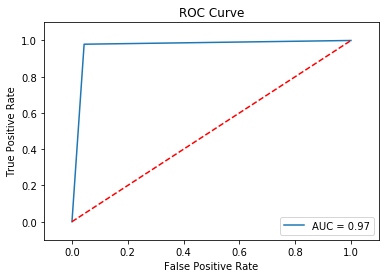

In [107]:
import matplotlib.pyplot as plt
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Y_train,Y_predict_train)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


### Test set 

นำข้อมูล 30 % ของที่มีนำมาเป็นตัวทดสอบ ข้อมูลนี้ไม่ถูกนำมา train จึงถือว่าเป็น unseen data

In [108]:
from sklearn.metrics import confusion_matrix
print("The Confusion Metrix of feature of test set")
unique_label = np.unique(Y_test)
print(pd.DataFrame(confusion_matrix(Y_test,
                                    Y_predict_test,labels=unique_label), 
                index=['true:{:}'.format(x) for x in unique_label], 
                columns=['pred:{:}'.format(x) for x in unique_label]))

The Confusion Metrix of feature of test set
          pred:0.0  pred:1.0
true:0.0    530793     24582
true:1.0       260      3424


In [109]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score

print(classification_report_imbalanced(Y_test,Y_predict_test))
print('true accuracy', accuracy_score(Y_test,Y_predict_test))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.96      0.93      0.98      0.94      0.89    555375
        1.0       0.12      0.93      0.96      0.22      0.94      0.89      3684

avg / total       0.99      0.96      0.93      0.97      0.94      0.89    559059

true accuracy 0.9555646184034243


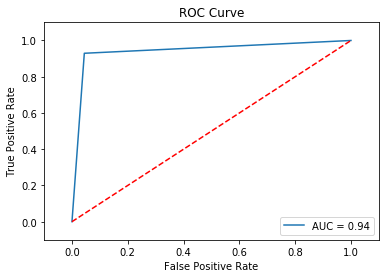

In [110]:
import matplotlib.pyplot as plt
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Y_test,Y_predict_test)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [111]:
prediction  = pd.DataFrame(Y_predict_test_prob, columns=['predict_prob_0', 'prdict_prob_1'])

In [112]:
For_hist = pd.concat([prediction, Y_test.reset_index()], axis = 1).set_index(['personid', 'accidentdate'])

In [113]:
For_hist.head(5)

,,predict_prob_0,prdict_prob_1,target
personid,accidentdate,,,
9000094008198,2018-09-02,0.989599,0.010401,0.0
9000092482695,2015-06-24,0.656843,0.343157,0.0
9000000646139,2014-06-06,0.993916,0.006084,0.0
1000003479110,2017-07-01,0.998141,0.001859,0.0
1000002922519,2014-05-06,0.046894,0.953106,0.0


รูปแสดงการกระจายตัวของความน่าจะเป็นเมือ predict แต่ล่ะ class ใน test set

## Fraud Class

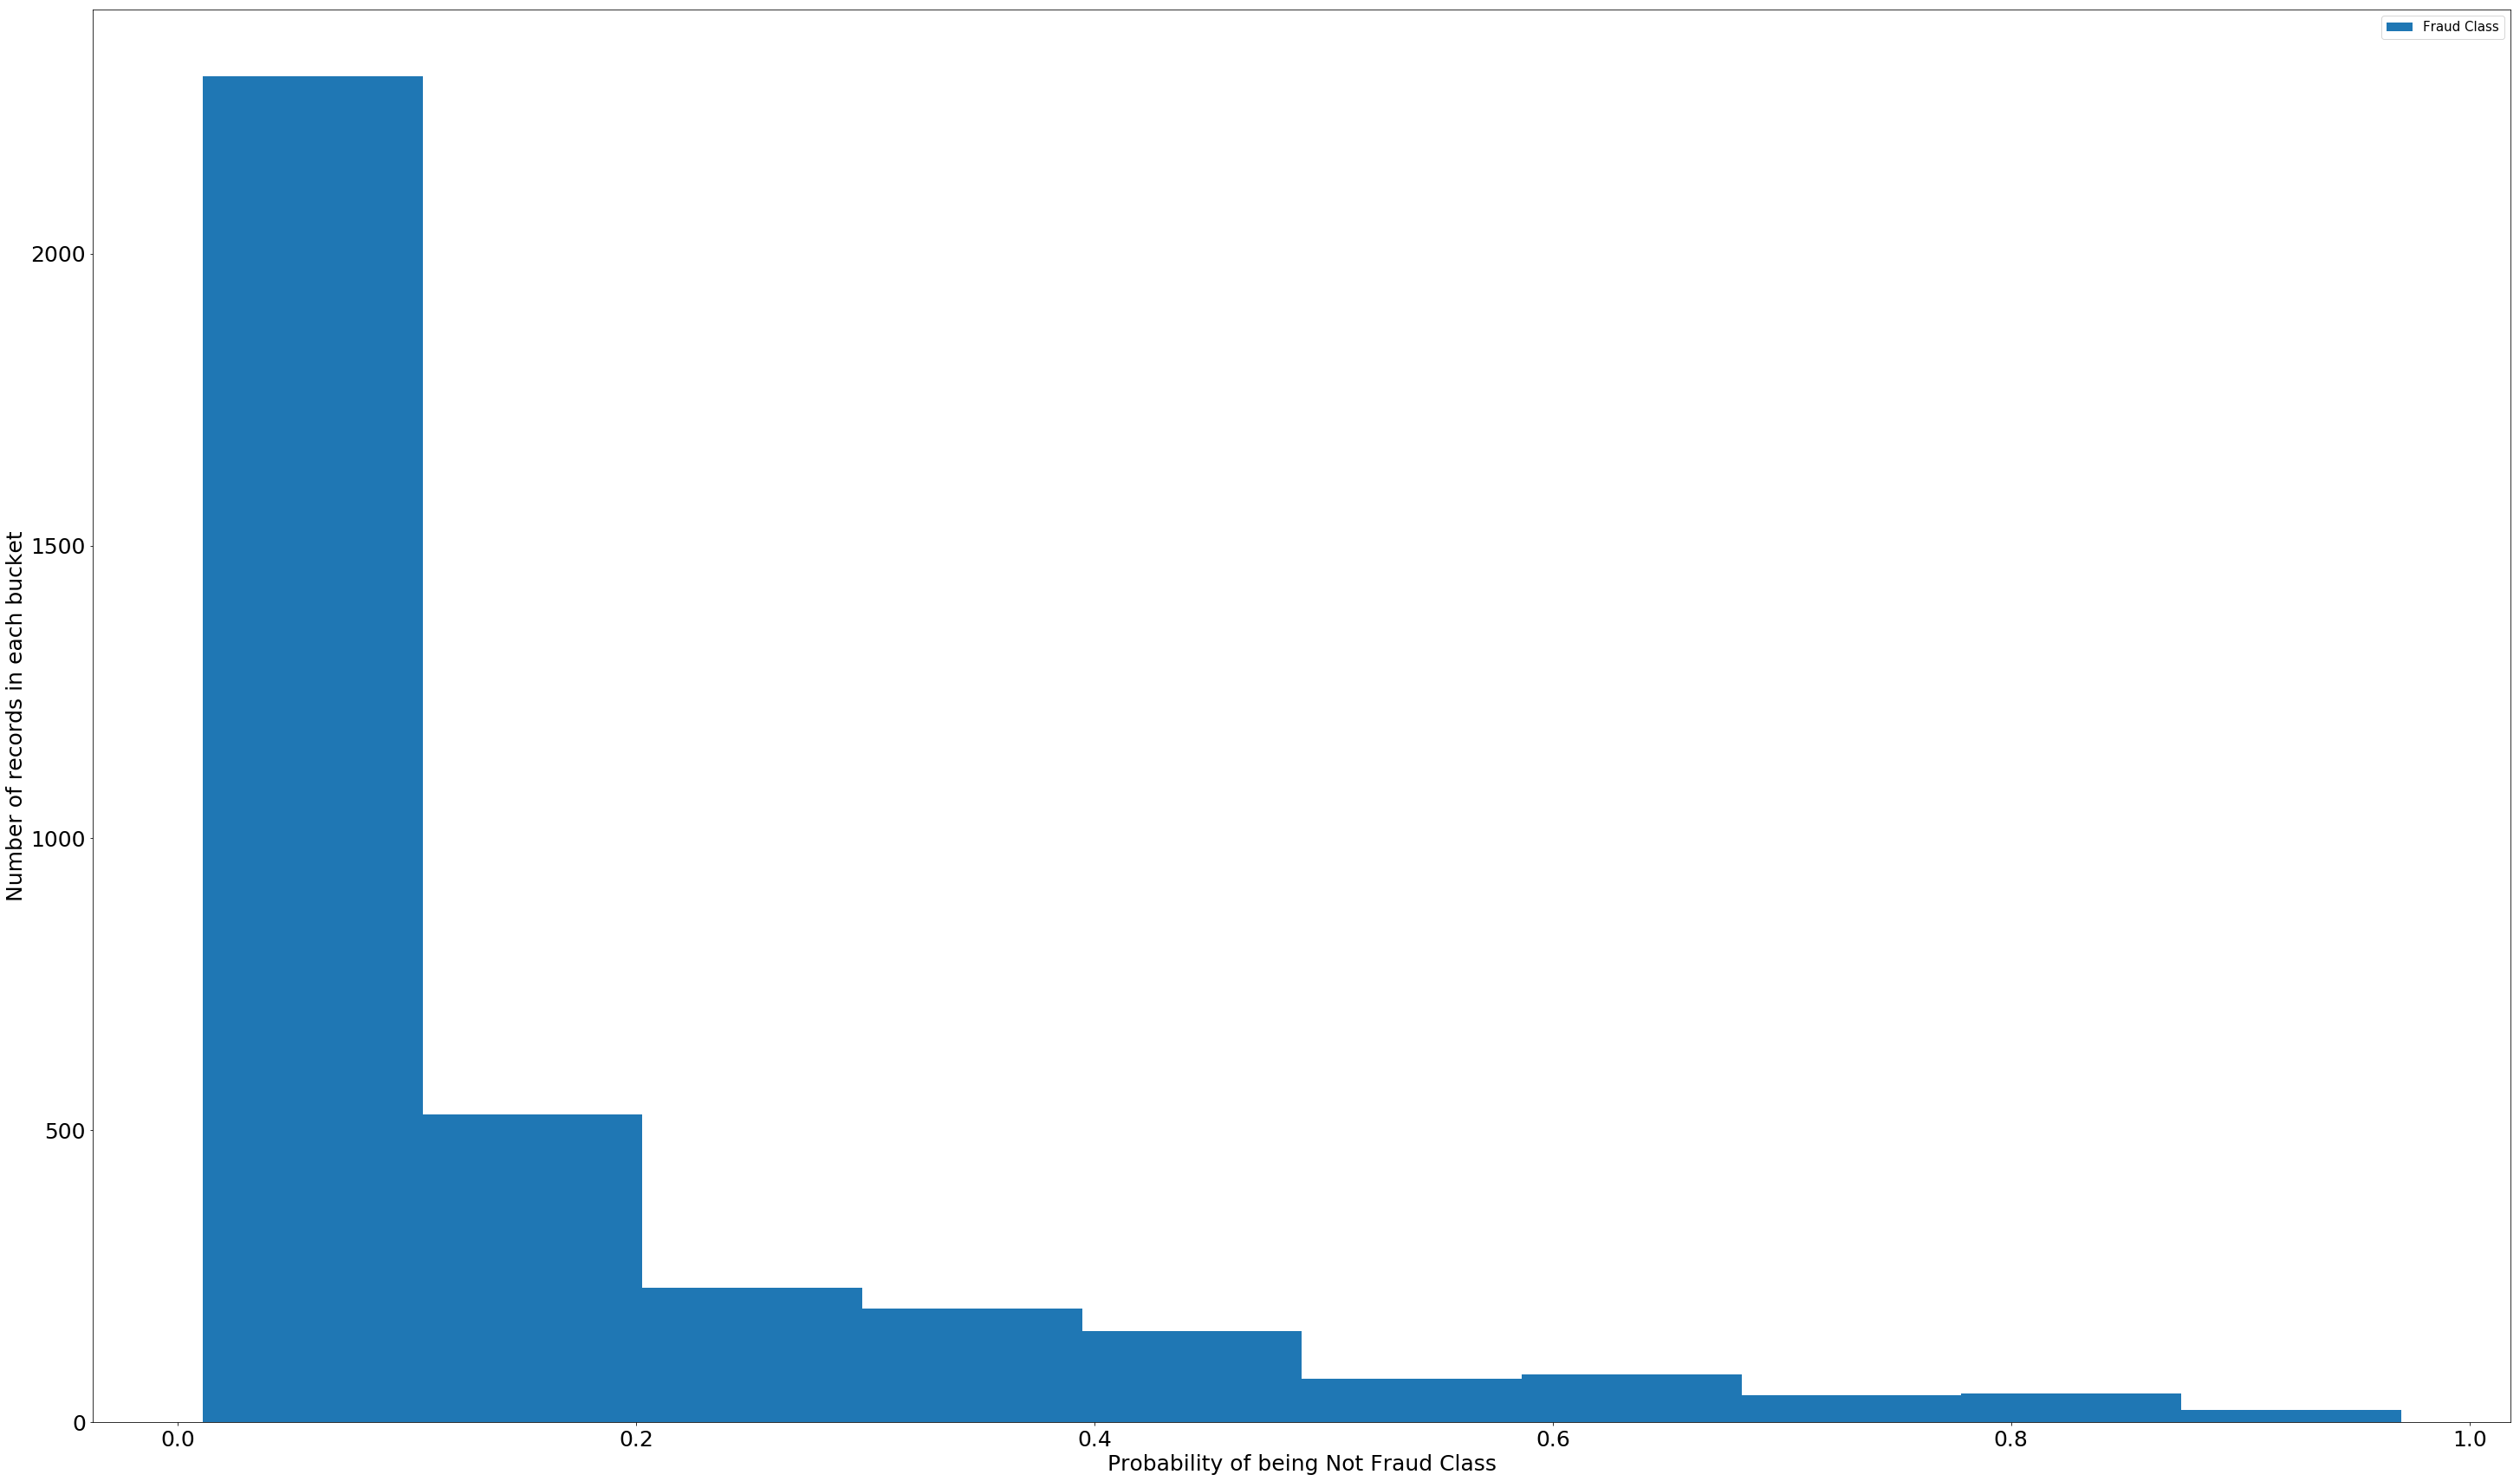

In [114]:
plt.figure(figsize=(50,30))
plt.hist(For_hist[For_hist['target'] == 1].predict_prob_0, bins=10, label='Fraud Class')
plt.xlabel('Probability of being Not Fraud Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

## Not Fraud Class

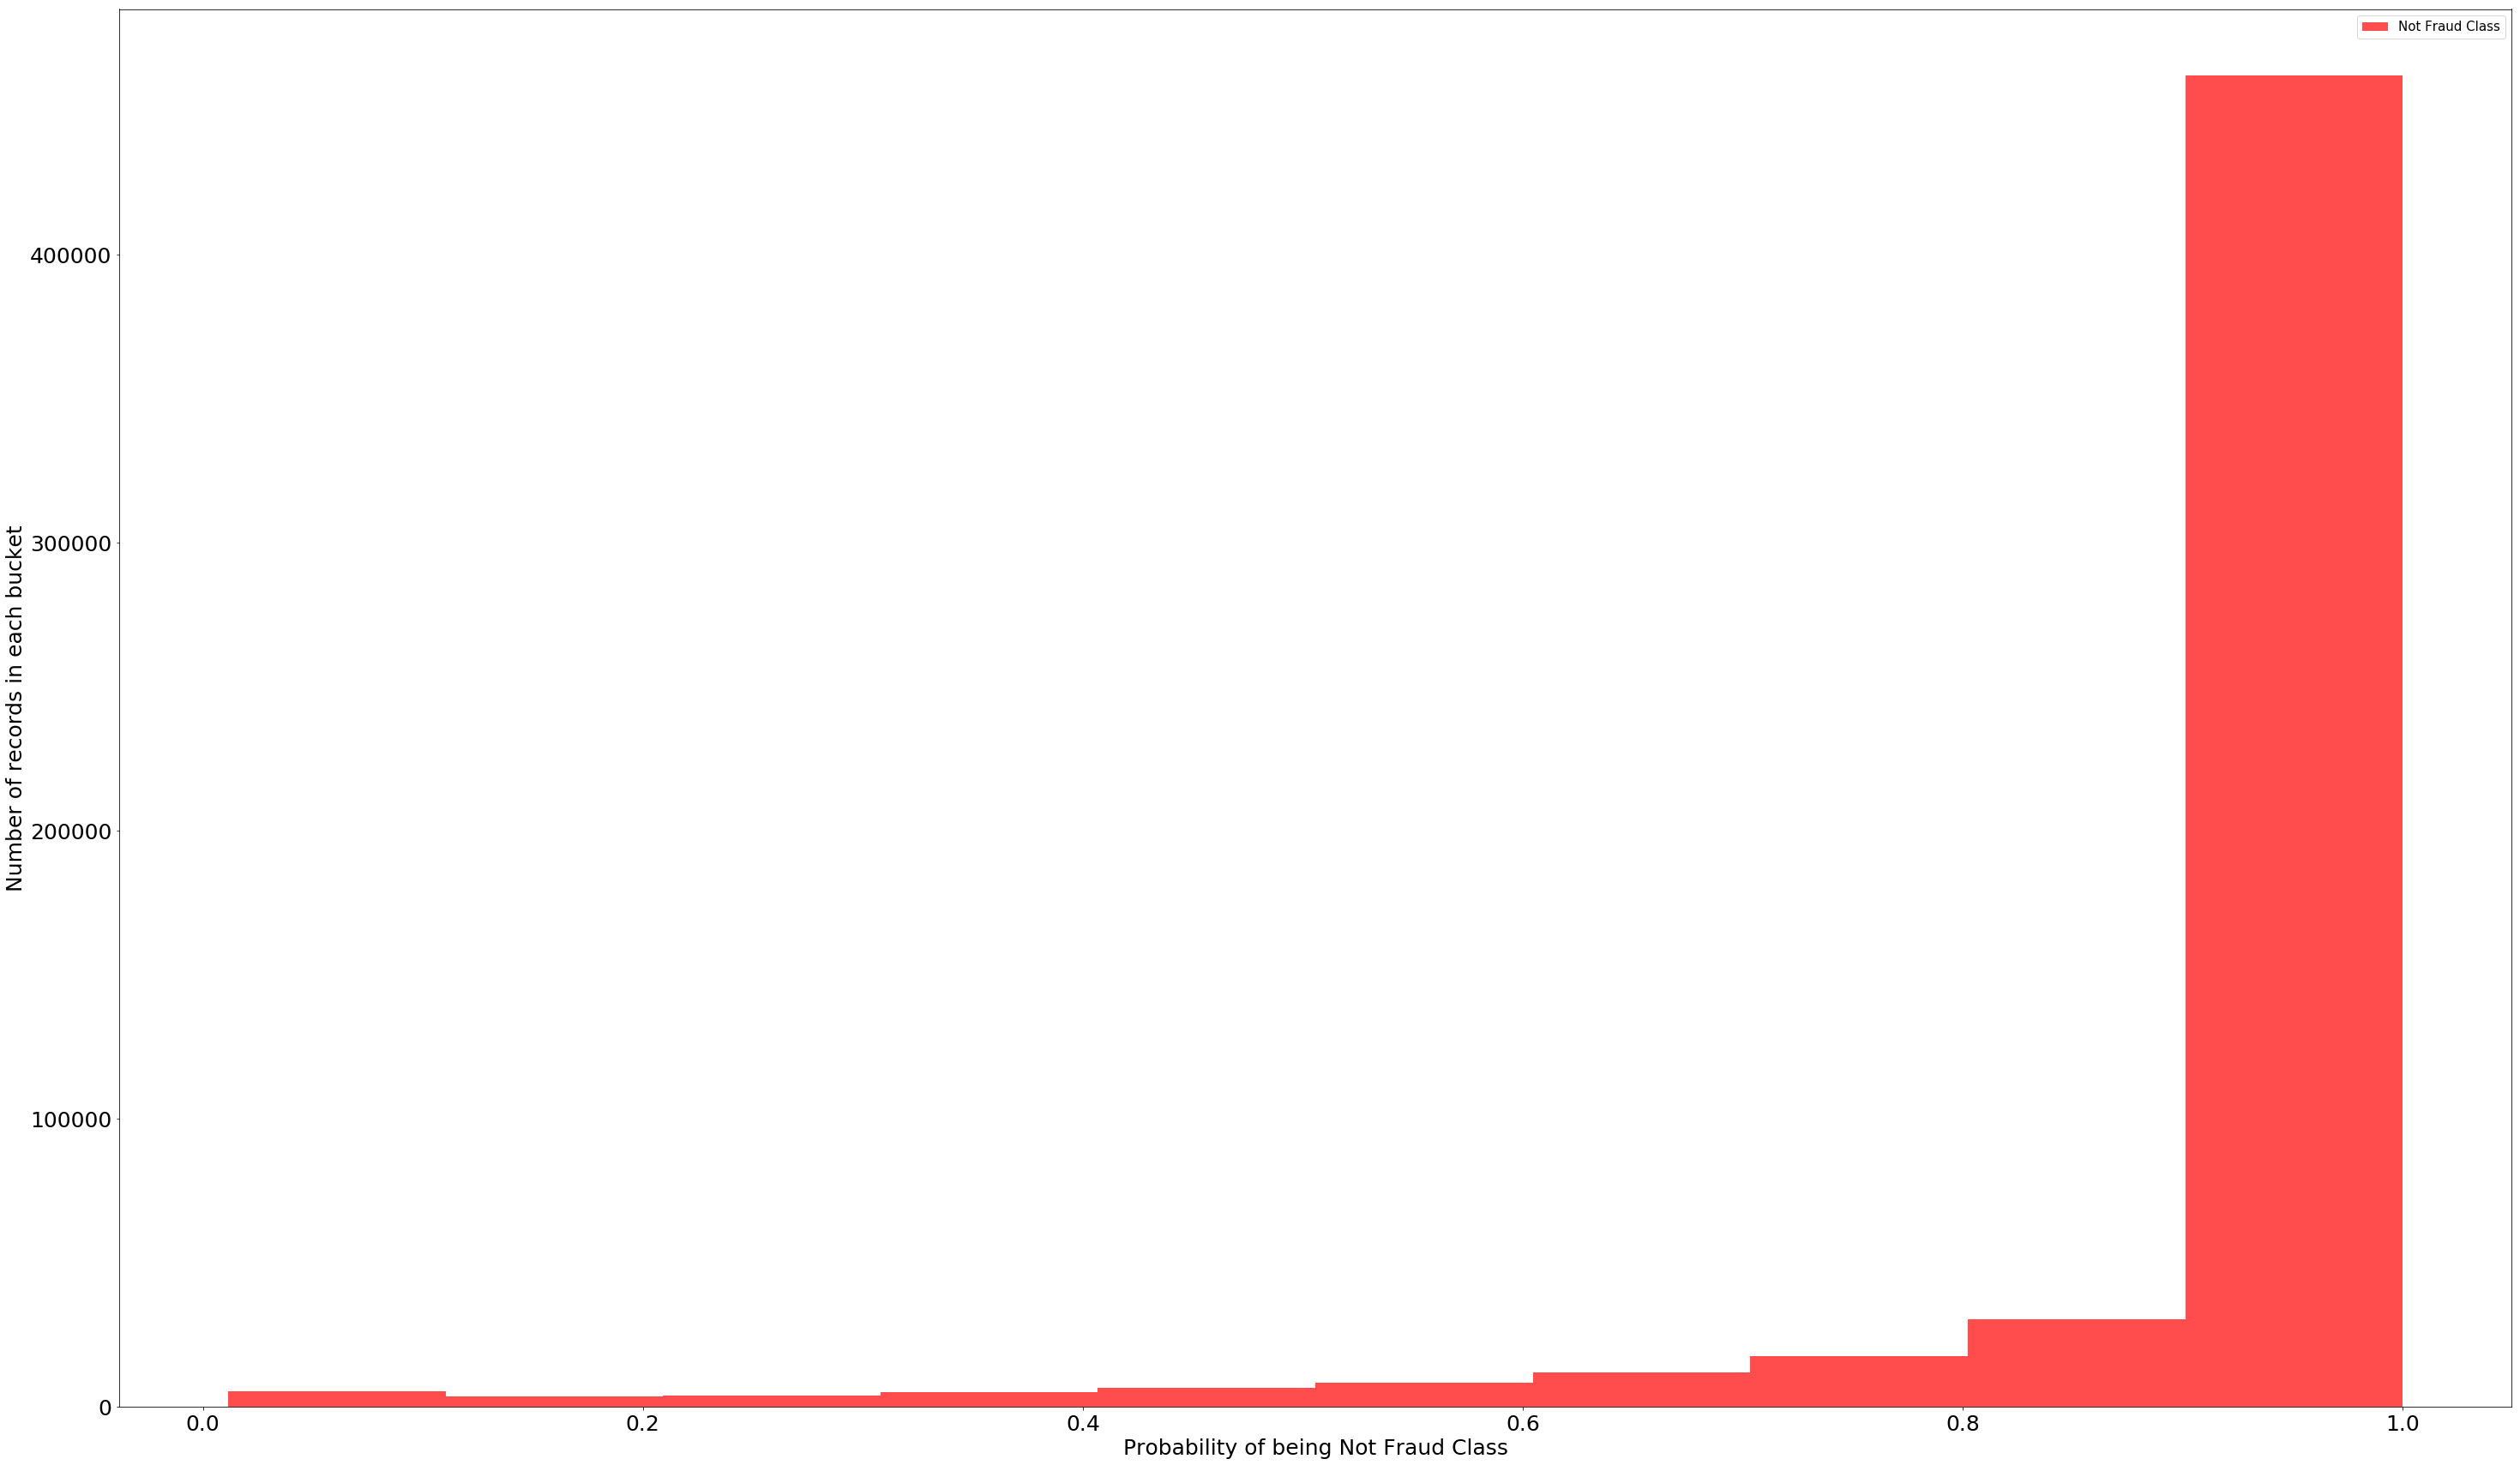

In [115]:
plt.figure(figsize=(50,30))
plt.hist(For_hist[For_hist['target'] == 0].predict_prob_0, bins=10, label='Not Fraud Class', alpha=0.7, color='r')
plt.xlabel('Probability of being Not Fraud Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()